# インテグレーションステップ プロジェクト

In [275]:
%matplotlib inline
import pandas as pd
import pandas.io.sql as psql
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

import scipy as sp
from scipy import stats
from scipy.stats import spearmanr

import psycopg2
from pandas import DataFrame
from __future__ import print_function

#xgboostをインポート
import xgboost as xgb
from sklearn.cross_validation import StratifiedKFold

#Scikit-learnをインポート
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import AdaBoostClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

#不均衡サンプリング
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

In [276]:
db_params = {
    'dbname': 'postgres',
    'user': 'postgres',
    'password': 'takashdb',
    'host': 'localhost',
    'port': 5432
}

con = psycopg2.connect(**db_params)

In [277]:
your_sql = """
select league_id, to_number(period,'9999') as period, to_number(substring(game_date, 2),'99') as game_month,
 player_cd, player_name, player_no, team_cd, team_cd_dl, team_name, pposition, age, years, pitching_type, batting_type, birth_place, fee, birth_date, 
 game, 
 -- trunc(era_total,0) as era_total, out_total, whip_total, dips_total, 
 to_number(game_sec,'99') as game_sec, game_cd, game_date, game_date_diff, game_stadium, home_team_cd, 
 CASE WHEN ground_type = '屋内' THEN 'IN'
      ELSE 'OUT'
      END as ground_type,
 versus_team, score, game_result, appearance, player_result, era, inning, outs, pitch, batter, hit, hr, hitrate, 
 struckout, fourball, deadball, shunned, run, earned_run,
 complete_game, complete_blockade, nohit_norun, "QS", "HQS", "JQS", "WHIP", 
 avg_max_speed, avg_min_speed, avg_speed_diff, max_speed, min_speed, speed_diff, 
 0 - ABS(max_speed_effect) as max_speed_effect, 0 - ABS(min_speed_effect) as min_speed_effect,
 --sum_game_1d, sum_inning_1d, sum_out_1d, sum_pitch_1d, sum_batter_1d, sum_struckout_1d, sum_fourball_1d, sum_deadball_1d, sum_run_1d, sum_earned_run_1d, max_speed_1d, min_speed_1d, speed_diff_1d, 0-abs(max_speed_effect_1d) as max_speed_effect_1d, 0-abs(min_speed_effect_1d) as min_speed_effect_1d,
 --sum_game_2d, sum_inning_2d, sum_out_2d, sum_pitch_2d, sum_batter_2d, sum_struckout_2d, sum_fourball_2d, sum_deadball_2d, sum_run_2d, sum_earned_run_2d, max_speed_2d, min_speed_2d, speed_diff_2d, 0-abs(max_speed_effect_2d) as max_speed_effect_2d, 0-abs(min_speed_effect_2d) as min_speed_effect_2d,
 --sum_game_3d, sum_inning_3d, sum_out_3d, sum_pitch_3d, sum_batter_3d, sum_struckout_3d, sum_fourball_3d, sum_deadball_3d, sum_run_3d, sum_earned_run_3d, max_speed_3d, min_speed_3d, speed_diff_3d, 0-abs(max_speed_effect_3d) as max_speed_effect_3d, 0-abs(min_speed_effect_3d) as min_speed_effect_3d,
 --sum_game_4d, sum_inning_4d, sum_out_4d, sum_pitch_4d, sum_batter_4d, sum_struckout_4d, sum_fourball_4d, sum_deadball_4d, sum_run_4d, sum_earned_run_4d, max_speed_4d, min_speed_4d, speed_diff_4d, 0-abs(max_speed_effect_4d) as max_speed_effect_4d, 0-abs(min_speed_effect_4d) as min_speed_effect_4d,
 --sum_game_5d, sum_inning_5d, sum_out_5d, sum_pitch_5d, sum_batter_5d, sum_struckout_5d, sum_fourball_5d, sum_deadball_5d, sum_run_5d, sum_earned_run_5d, max_speed_5d, min_speed_5d, speed_diff_5d, 0-abs(max_speed_effect_5d) as max_speed_effect_5d, 0-abs(min_speed_effect_5d) as min_speed_effect_5d,
 --sum_game_6d, sum_inning_6d, sum_out_6d, sum_pitch_6d, sum_batter_6d, sum_struckout_6d, sum_fourball_6d, sum_deadball_6d, sum_run_6d, sum_earned_run_6d, max_speed_6d, min_speed_6d, speed_diff_6d, 0-abs(max_speed_effect_6d) as max_speed_effect_6d, 0-abs(min_speed_effect_6d) as min_speed_effect_6d,
 --sum_game_7d, sum_inning_7d, sum_out_7d, sum_pitch_7d, sum_batter_7d, sum_struckout_7d, sum_fourball_7d, sum_deadball_7d, sum_run_7d, sum_earned_run_7d, max_speed_7d, min_speed_7d, speed_diff_7d, 0-abs(max_speed_effect_7d) as max_speed_effect_7d, 0-abs(min_speed_effect_7d) as min_speed_effect_7d,
 cnt_relief, relief_flg, run_flg, 
 run_po, erun_po, ppo, hb_po,
 --run_po_d1, erun_po_d1, ppo_d1, hb_po_d1,
 --run_po_d2, erun_po_d2, ppo_d2, hb_po_d2,
 --run_po_d3, erun_po_d3, ppo_d3, hb_po_d3,
 --run_po_d4, erun_po_d4, ppo_d4, hb_po_d4,
 --run_po_d5, erun_po_d5, ppo_d5, hb_po_d5,
 --run_po_d6, erun_po_d6, ppo_d6, hb_po_d6,
-- run_po_d7, erun_po_d7, ppo_d7, hb_po_d7,
 CASE WHEN earned_run > 0 THEN 1
      ELSE 0
      END as earned_run_flg,
 CASE WHEN ppo >= 7 THEN 1
      ELSE 0
      END as ppo_level,
 CASE WHEN hb_po >= 1 THEN 1
      ELSE 0
      END as hb_po_level
  from baseball.v_analytics_for_reliefpitch
-- where appearance = '救援' and cnt_relief >= 40 
 where appearance = '救援' and team_cd_dl = 'DB'
-- where appearance = '救援' and team_cd_dl in ('H','C','T')
"""

In [278]:
data = psql.read_sql(con=con, sql=your_sql)
data

,league_id,period,game_month,player_cd,player_name,player_no,team_cd,team_cd_dl,team_name,pposition,...,cnt_relief,relief_flg,run_flg,run_po,erun_po,ppo,hb_po,earned_run_flg,ppo_level,hb_po_level
0,セ,2017.0,6.0,DBn12,小林 寛,12,D,DB,横浜DeNAベイスターズ,投手,...,3,N,0,0.00,0.00,6.0,1.0,0,0,1
1,セ,2017.0,6.0,DBn12,小林 寛,12,D,DB,横浜DeNAベイスターズ,投手,...,3,N,0,0.00,0.00,8.0,1.0,0,1,1
2,セ,2017.0,7.0,DBn12,小林 寛,12,D,DB,横浜DeNAベイスターズ,投手,...,3,N,0,0.00,0.00,7.0,1.0,0,1,1
3,セ,2017.0,0.0,DBn15,井納 翔一,15,D,DB,横浜DeNAベイスターズ,投手,...,1,N,0,0.00,0.00,4.0,0.0,0,0,0
4,セ,2017.0,5.0,DBn16,加賀 繁,16,D,DB,横浜DeNAベイスターズ,投手,...,33,N,0,0.00,0.00,8.0,0.0,0,1,0
5,セ,2017.0,5.0,DBn16,加賀 繁,16,D,DB,横浜DeNAベイスターズ,投手,...,33,N,0,0.00,0.00,7.0,1.0,0,1,1
6,セ,2017.0,5.0,DBn16,加賀 繁,16,D,DB,横浜DeNAベイスターズ,投手,...,33,N,1,0.67,0.67,10.0,1.0,1,1,1
7,セ,2017.0,5.0,DBn16,加賀 繁,16,D,DB,横浜DeNAベイスターズ,投手,...,33,N,0,0.00,0.00,6.0,0.0,0,0,0
8,セ,2017.0,5.0,DBn16,加賀 繁,16,D,DB,横浜DeNAベイスターズ,投手,...,33,N,0,0.00,0.00,5.0,0.0,0,0,0
9,セ,2017.0,5.0,DBn16,加賀 繁,16,D,DB,横浜DeNAベイスターズ,投手,...,33,N,0,0.00,0.00,3.0,0.0,0,0,0


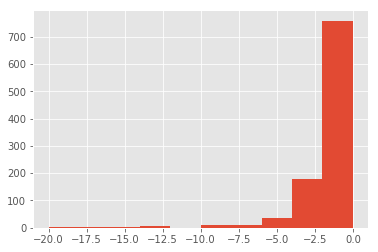

In [279]:
#データの分布（ヒストグラム）
#data['ppo'].hist()
data['max_speed_effect'].hist()

In [280]:
#クラスタデータのインポート
rp_cluster = pd.read_csv('rp_output.csv')

rp_cluster2016 = rp_cluster[rp_cluster['period'] ==2016]
rp_cluster2016['cluster_id_past'] = rp_cluster2016['cluster_id']

rp_colnames = ['period','cluster_id']
rp_cluster2016 = rp_cluster2016.drop(rp_colnames, axis=1)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [281]:
data = pd.merge(data, rp_cluster2016, how='left', on=('player_cd'))

In [282]:
data = pd.merge(data, rp_cluster, how='left', on=('period','player_cd'))
data

,league_id,period,game_month,player_cd,player_name,player_no,team_cd,team_cd_dl,team_name,pposition,...,run_flg,run_po,erun_po,ppo,hb_po,earned_run_flg,ppo_level,hb_po_level,cluster_id_past,cluster_id
0,セ,2017,6.0,DBn12,小林 寛,12,D,DB,横浜DeNAベイスターズ,投手,...,0,0.00,0.00,6.0,1.0,0,0,1,NaN,NaN
1,セ,2017,6.0,DBn12,小林 寛,12,D,DB,横浜DeNAベイスターズ,投手,...,0,0.00,0.00,8.0,1.0,0,1,1,NaN,NaN
2,セ,2017,7.0,DBn12,小林 寛,12,D,DB,横浜DeNAベイスターズ,投手,...,0,0.00,0.00,7.0,1.0,0,1,1,NaN,NaN
3,セ,2017,0.0,DBn15,井納 翔一,15,D,DB,横浜DeNAベイスターズ,投手,...,0,0.00,0.00,4.0,0.0,0,0,0,NaN,NaN
4,セ,2017,5.0,DBn16,加賀 繁,16,D,DB,横浜DeNAベイスターズ,投手,...,0,0.00,0.00,8.0,0.0,0,1,0,NaN,NaN
5,セ,2017,5.0,DBn16,加賀 繁,16,D,DB,横浜DeNAベイスターズ,投手,...,0,0.00,0.00,7.0,1.0,0,1,1,NaN,NaN
6,セ,2017,5.0,DBn16,加賀 繁,16,D,DB,横浜DeNAベイスターズ,投手,...,1,0.67,0.67,10.0,1.0,1,1,1,NaN,NaN
7,セ,2017,5.0,DBn16,加賀 繁,16,D,DB,横浜DeNAベイスターズ,投手,...,0,0.00,0.00,6.0,0.0,0,0,0,NaN,NaN
8,セ,2017,5.0,DBn16,加賀 繁,16,D,DB,横浜DeNAベイスターズ,投手,...,0,0.00,0.00,5.0,0.0,0,0,0,NaN,NaN
9,セ,2017,5.0,DBn16,加賀 繁,16,D,DB,横浜DeNAベイスターズ,投手,...,0,0.00,0.00,3.0,0.0,0,0,0,NaN,NaN


クレンジング

In [283]:
#欠損値の対応
data['run_po'] = data['run_po'].replace(np.NaN,0)
data['erun_po'] = data['erun_po'].replace(np.NaN,0)
data['ppo'] = data['ppo'].replace(np.NaN,0)
data['hb_po'] = data['hb_po'].replace(np.NaN,0)

#data['sum_game_7d'] = data['sum_game_7d'].replace(np.NaN,0)
#data['sum_inning_7d'] = data['sum_inning_7d'].replace(np.NaN,0)
#data['sum_out_7d'] = data['sum_out_7d'].replace(np.NaN,0)
#data['sum_pitch_7d'] = data['sum_pitch_7d'].replace(np.NaN,0)
#data['sum_batter_7d'] = data['sum_batter_7d'].replace(np.NaN,0)
#data['sum_struckout_7d'] = data['sum_struckout_7d'].replace(np.NaN,0)
#data['sum_fourball_7d'] = data['sum_fourball_7d'].replace(np.NaN,0)
#data['sum_deadball_7d'] = data['sum_deadball_7d'].replace(np.NaN,0)
#data['sum_run_7d'] = data['sum_run_7d'].replace(np.NaN,0)
#data['sum_earned_run_7d'] = data['sum_earned_run_7d'].replace(np.NaN,0)
#data['max_speed_7d'] = data['max_speed_7d'].replace(np.NaN,0)
#data['min_speed_7d'] = data['min_speed_7d'].replace(np.NaN,0)
#data['speed_diff_7d'] = data['speed_diff_7d'].replace(np.NaN,0)
#data['max_speed_effect_7d'] = data['max_speed_effect_7d'].replace(np.NaN,0)
#data['min_speed_effect_7d'] = data['min_speed_effect_7d'].replace(np.NaN,0)
#data['run_po_d7'] = data['run_po_d7'].replace(np.NaN,0)
#data['erun_po_d7'] = data['erun_po_d7'].replace(np.NaN,0)
#data['ppo_d7'] = data['ppo_d7'].replace(np.NaN,0)
#data['hb_po_d7'] = data['hb_po_d7'].replace(np.NaN,0)

data['cluster_id'] = data['cluster_id'].replace(np.NaN,0)
data['cluster_id_past'] = data['cluster_id_past'].replace(np.NaN,0)

In [284]:
# カテゴリ変数のダミー変数作成
#colnames_categorical = ['league_id','team_cd','blood','pitching_type','game_stadium','home_team_cd','ground_type']
colnames_categorical = ['league_id','team_cd']
data_dummy = pd.get_dummies(data[colnames_categorical], drop_first=True)

# ダミー変数の結合
data_cate = pd.merge(data, data_dummy, left_index=True, right_index=True)

# 使わない、重複している列の削除
data_cate = data_cate.drop(colnames_categorical, axis=1)
data_cate = data

項目選択

In [285]:
#目的変数
target_col = ['run_po', 'run_flg']
#target_col = ['erun_po','earned_run_flg']
#target_col = ['ppo','ppo_level']
#target_col = ['hb_po','hb_po_level']
#target_col = ['run_po', 'run_flg', 'erun_po', 'earned_run_flg', 'ppo', 'ppo_level', 'hb_po', 'hb_po_level',]

#目的変数(回帰)
target_col_reg = ['run_po']
#target_col_reg = ['erun_po']
#target_col_reg = ['ppo']
#target_col_reg = ['hb_po']

#目的関数(分類)
target_col_cls = ['run_flg']
#target_col_cls = ['earned_run_flg']
#target_col_cls = ['ppo_level']
#target_col_cls = ['hb_po_level']

In [286]:
#ファイル出力用のデータ項目
include_cols = ['league_id','period','game_month','player_cd','player_name','player_no','team_cd','team_cd_dl','team_name','pposition',
                'age','years','pitching_type','batting_type','birth_place','fee','birth_date',
                'game', 'game_sec','game_cd','game_date','game_date_diff','game_stadium','home_team_cd','ground_type','versus_team',
                'score','game_result','appearance','player_result','era','inning','outs','pitch','batter','hit','hr','hitrate','struckout','fourball','deadball','shunned',
                'run','earned_run','complete_game','complete_blockade','nohit_norun',
                'avg_max_speed','avg_min_speed','avg_speed_diff','max_speed','min_speed','speed_diff','max_speed_effect','min_speed_effect',
#                'sum_game_7d','sum_inning_7d','sum_out_7d','sum_pitch_7d','sum_batter_7d','sum_struckout_7d','sum_fourball_7d','sum_deadball_7d','sum_run_7d','sum_earned_run_7d','max_speed_7d','min_speed_7d','speed_diff_7d','max_speed_effect_7d','min_speed_effect_7d',
                'cnt_relief','relief_flg', 'run_po', 'run_flg', 'erun_po', 'earned_run_flg', 'ppo', 'ppo_level', 'hb_po', 'hb_po_level', 
#                'run_po_d7', 'erun_po_d7', 'ppo_d7', 'hb_po_d7',
                'cluster_id']

In [287]:
#説明変数からの除外項目
exclude_cols = ['league_id','team_cd','player_cd','game_stadium','home_team_cd','ground_type','inning','outs','era_total','player_name',
                'team_cd','team_cd_dl','team_name','pposition',
                'age','years','blood','pitching_type','batting_type','birth_place','fee','birth_date',
                'game_cd','game_date','game_stadium','home_team_cd','ground_type','versus_team', 'run','earned_run',
                'erun_po', 'earned_run_flg', 'ppo', 'ppo_level', 'hb_po', 'hb_po_level',
                'score','game_result','appearance','player_result','era','batter','hit','hr','hitrate','struckout','fourball','deadball','shunned',
                'complete_game','complete_blockade','nohit_norun','"QS"','"HQS"','"JQS"','"WHIP"','QS','HQS','JQS','WHIP',
                'relief_flg','data_type','cluster_id']

In [313]:
#説明変数の項目
process_cols = [col for col in data_cate.columns if col not in exclude_cols]
feature_cols = [col for col in data_cate.columns if col not in exclude_cols and col not in target_col]
feature_cols

['period',
 'game_month',
 'player_no',
 'game',
 'game_sec',
 'game_date_diff',
 'pitch',
 'avg_max_speed',
 'avg_min_speed',
 'avg_speed_diff',
 'max_speed',
 'min_speed',
 'speed_diff',
 'max_speed_effect',
 'min_speed_effect',
 'cnt_relief',
 'cluster_id_past']

データ分割

In [289]:
train_data = data[data['period'] !=2017]
test_data = data[data['period'] ==2017]

学習データの前処理

In [290]:
#学習データ（目的変数：回帰）
y_train = train_data[target_col_cls]

#学習データ（説明変数）
x_train = train_data[process_cols]

不均衡データのサンプリング

In [291]:
# 失点した試合数
#count_train = y_train_cls1[target_col_cls].sum()
count_train = y_train['run_flg'].sum()
print('失点した試合数: {}'.format(count_train))

失点した試合数: 78


#列の確認
col_names = x_train2a.columns
for col_name in col_names:
    print(col_name)

In [292]:
#学習データの変数設定
y_train_cls = x_train[target_col_cls]
y_train_reg = x_train[target_col_reg]
x_train_t = x_train[feature_cols]

テストデータの前処理

In [293]:
#テストデータ（目的変数：回帰）
y_test_reg = test_data[target_col_reg]

#テストデータ（目的変数：分類）
y_test_cls = test_data[target_col_cls]

#テストデータ（ファイル出力用）
x_test_out = test_data[include_cols]

#テストデータ（説明変数）
x_test = test_data[feature_cols]

共通部品

In [294]:
def varImpPlot(clf, feature_names, topN = 10, verbose = True):
    feature_names = np.array(feature_names)
    feature_importance = clf.feature_importances_
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    
    topN_feature = feature_importance[sorted_idx][len(feature_importance) - topN:]
    topN_feature_name = feature_names[sorted_idx][len(feature_importance) - topN:]
    pos = np.arange(topN) + .5
    plt.barh(pos, topN_feature, align='center')
    plt.yticks(pos, topN_feature_name)
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance')
    plt.show()
    
    rev_sorted_idx = np.argsort(feature_importance)[::-1]
    if verbose:
        for i, v in zip(feature_names[rev_sorted_idx], feature_importance[rev_sorted_idx]):
            print(i, v)

# 予測の実行

ランダムフォレスト（回帰）

In [295]:
x_train_t.head(10)

,period,game_month,player_no,game,game_sec,game_date_diff,pitch,avg_max_speed,avg_min_speed,avg_speed_diff,max_speed,min_speed,speed_diff,max_speed_effect,min_speed_effect,cnt_relief,cluster_id_past
52,2015,3.0,19,58.0,1.0,30,9.0,147.0,131.0,16.0,149.0,134.0,15.0,-2.0,-3.0,58,1.0
53,2015,3.0,19,58.0,2.0,3,18.0,147.0,131.0,16.0,151.0,137.0,14.0,-4.0,-6.0,58,1.0
54,2015,4.0,19,58.0,3.0,1,28.0,147.0,131.0,16.0,145.0,124.0,21.0,-2.0,-7.0,58,1.0
55,2015,4.0,19,58.0,4.0,4,17.0,147.0,131.0,16.0,148.0,127.0,21.0,-1.0,-4.0,58,1.0
56,2015,4.0,19,58.0,5.0,4,12.0,147.0,131.0,16.0,149.0,128.0,21.0,-2.0,-3.0,58,1.0
57,2015,4.0,19,58.0,6.0,2,13.0,147.0,131.0,16.0,146.0,123.0,23.0,-1.0,-8.0,58,1.0
58,2015,4.0,19,58.0,7.0,1,15.0,147.0,131.0,16.0,144.0,128.0,16.0,-3.0,-3.0,58,1.0
59,2015,4.0,19,58.0,8.0,7,28.0,147.0,131.0,16.0,146.0,118.0,28.0,-1.0,-13.0,58,1.0
60,2015,4.0,19,58.0,9.0,2,21.0,147.0,131.0,16.0,148.0,126.0,22.0,-1.0,-5.0,58,1.0
61,2015,4.0,19,58.0,10.0,1,17.0,147.0,131.0,16.0,146.0,128.0,18.0,-1.0,-3.0,58,1.0


In [296]:
#学習用データでランダムフォレスト（回帰）の学習処理
#rfreg = RandomForestRegressor(n_estimators = 100, max_depth = 10, max_features = 'sqrt')
rfreg = RandomForestRegressor()
rfreg.fit(x_train_t, y_train_reg)
rfreg.score(x_train_t, y_train_reg)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


0.72379744125319379

In [297]:
y_pred_rfreg_train = rfreg.predict(x_train_t)

#テストデータで予測処理
y_pred_rfreg_t = rfreg.predict(x_test)
y_pred_rfreg_t_r = np.round(y_pred_rfreg_t)

#テストデータでMSEとR2乗の検証
print('MSE test : %.3f' % (mean_squared_error(y_test_reg, y_pred_rfreg_t)))
print('R^2 test : %.3f' % (r2_score(y_test_reg, y_pred_rfreg_t)))

MSE test : 0.293
R^2 test : -0.075


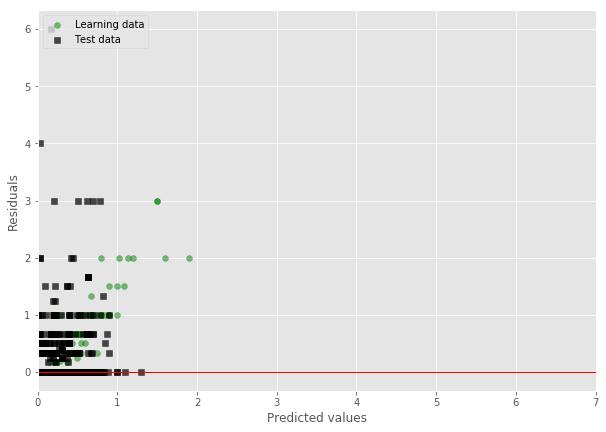

In [298]:
plt.figure(figsize = (10, 7))
plt.scatter(y_pred_rfreg_train, y_train_reg, c = 'green', marker = 'o', s = 35, alpha = 0.5, label = 'Learning data')
plt.scatter(y_pred_rfreg_t, y_test_reg, c = 'black', marker = 's', s = 35, alpha = 0.7, label = 'Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc = 'upper left')
plt.hlines(y = 0, xmin = 0, xmax = 7, lw = 1, color = 'red')
plt.xlim([0, 7])
plt.show()

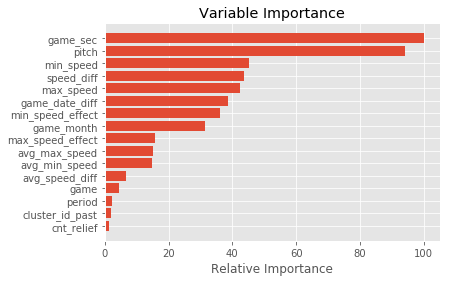

In [299]:
varImpPlot(rfreg, feature_cols, topN=16, verbose=False)

ランダムフォレスト（分類）

In [300]:
#学習用データでランダムフォレスト（分類）の学習処理
#rfcls = RandomForestClassifier(n_estimators = 100, max_depth = 10, class_weight = "balanced", max_leaf_nodes = 1000)
rfcls = RandomForestClassifier(class_weight = "balanced")
rfcls.fit(x_train_t, y_train_cls)
rfcls.score(x_train_t, y_train_cls)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


0.95959595959595956

#グリッドサーチでハイパーパラメータを検討
parameters = {'n_estimators':[100,200], 'max_depth':[10,20,30]}
rfcls = GridSearchCV(RandomForestClassifier(), parameters)
rfcls.fit(x_train2, y_train_cls2)
print(rfcls.best_estimator_)

In [301]:
#テストデータで予測処理
y_pred_rfcls_t = rfcls.predict(x_test)

#テストデータで正解率を検証
accuracy_score(y_test_cls, y_pred_rfcls_t)

0.72712418300653592

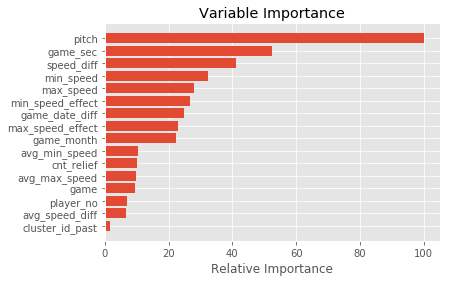

In [302]:
varImpPlot(rfcls, feature_cols, topN=16, verbose=False)

勾配ブースティング（ADABoost）（回帰）

In [303]:
#学習用データでランダムフォレスト（分類）の学習処理
adareg = AdaBoostRegressor()
adareg.fit(x_train_t, y_train_reg)
adareg.score(x_train_t, y_train_reg)

C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.24460110861956788

In [265]:
#パラメータチューニング用データで予測処理
y_pred_adareg = adareg.predict(x_train_t)

In [304]:
#テストデータで予測処理
y_pred_adareg_t = adareg.predict(x_test)
y_pred_adareg_t_r = np.round(y_pred_adareg_t)

#テストデータでMSEとR2乗の検証
print('MSE test : %.3f' % (mean_squared_error(y_test_reg, y_pred_adareg_t)))
print('R^2 test : %.3f' % (r2_score(y_test_reg, y_pred_adareg_t)))

MSE test : 0.327
R^2 test : -0.200


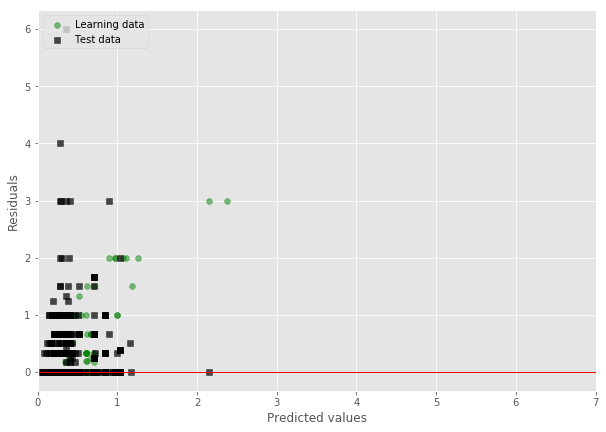

In [305]:
plt.figure(figsize = (10, 7))
plt.scatter(y_pred_adareg, y_train_reg, c = 'green', marker = 'o', s = 35, alpha = 0.5, label = 'Learning data')
#plt.scatter(y_pred_adareg2, y_train_reg2, c = 'blue', marker = 'o', s = 35, alpha = 0.5, label = 'Training data')
plt.scatter(y_pred_adareg_t, y_test_reg, c = 'black', marker = 's', s = 35, alpha = 0.7, label = 'Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc = 'upper left')
plt.hlines(y = 0, xmin = 0, xmax = 7, lw = 1, color = 'red')
plt.xlim([0, 7])
plt.show()

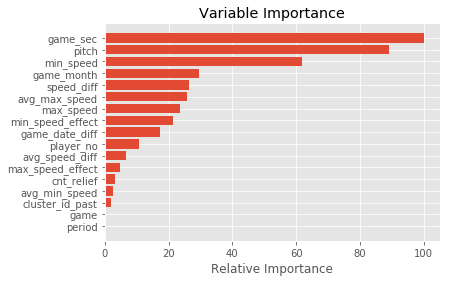

In [306]:
varImpPlot(ada, feature_cols, topN=17, verbose=False)

勾配ブースティング（ADABoost）（分類）

In [307]:
#学習用データでランダムフォレスト（分類）の学習処理
adacls = AdaBoostClassifier()
adacls.fit(x_train_t, y_train_cls)
adacls.score(x_train_t, y_train_cls)

C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.86363636363636365

In [308]:
#パラメータチューニング用データで予測処理
y_pred_adacls = adacls.predict(x_train_t)

In [309]:
#テストデータで予測処理
y_pred_adacls_t = adacls.predict(x_test)

#テストデータで正解率を検証
accuracy_score(y_test_cls, y_pred_adacls_t)

0.7009803921568627

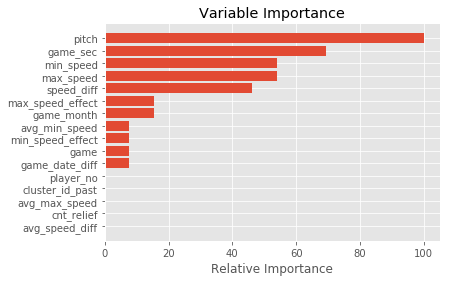

In [310]:
varImpPlot(adacls, feature_cols, topN=16, verbose=False)

データ出力

In [311]:
output = DataFrame({
'REG_predict01_rf': y_pred_rfreg_t, 
'REG_predict02_ada': y_pred_adareg_t,
'REG_actual': y_test_reg['run_po'].values, 
'CLS_predict01_rf': y_pred_rfcls_t,
'CLS_predict02_ada': y_pred_adacls_t,
'CLS_actual': y_test_cls['run_flg'].values,
'001league_id': x_test_out['league_id'], 
'002period': x_test_out['period'], 
'003game_month': x_test_out['game_month'], 
'004player_cd': x_test_out['player_cd'], 
'005player_name': x_test_out['player_name'], 
'006player_no': x_test_out['player_no'], 
'007team_cd': x_test_out['team_cd'], 
'008team_cd_dl': x_test_out['team_cd_dl'], 
'009team_name': x_test_out['team_name'], 
'010pposition': x_test_out['pposition'], 
'011age': x_test_out['age'], 
'012years': x_test_out['years'],
'013pitching_type': x_test_out['pitching_type'], 
'014batting_type': x_test_out['batting_type'], 
'015birth_place': x_test_out['birth_place'], 
'016fee': x_test_out['fee'], 
'017birth_date': x_test_out['birth_date'], 
'018game_sec': x_test_out['game_sec'], 
'019game_cd': x_test_out['game_cd'], 
'020game_date': x_test_out['game_date'], 
'021game_date_diff': x_test_out['game_date_diff'], 
'022game_stadium': x_test_out['game_stadium'], 
'023home_team_cd': x_test_out['home_team_cd'], 
'024ground_type': x_test_out['ground_type'], 
'025versus_team': x_test_out['versus_team'], 
'026score': x_test_out['score'], 
'027game_result': x_test_out['game_result'], 
'028appearance': x_test_out['appearance'], 
'029player_result': x_test_out['player_result'], 
'030era': x_test_out['era'], 
'031inning': x_test_out['inning'], 
'032outs': x_test_out['outs'], 
'033pitch': x_test_out['pitch'], 
'034batter': x_test_out['batter'], 
'035hit': x_test_out['hit'], 
'036hr': x_test_out['hr'], 
'037hitrate': x_test_out['hitrate'], 
'038struckout': x_test_out['struckout'], 
'039fourball': x_test_out['fourball'], 
'040deadball': x_test_out['deadball'], 
'041shunned': x_test_out['shunned'], 
'042run': x_test_out['run'], 
'043earned_run': x_test_out['earned_run'], 
'044complete_game': x_test_out['complete_game'], 
'045complete_blockade': x_test_out['complete_blockade'], 
'046nohit_norun': x_test_out['nohit_norun'], 
'047avg_max_speed': x_test_out['avg_max_speed'], 
'048avg_min_speed': x_test_out['avg_min_speed'], 
'049avg_speed_diff': x_test_out['avg_speed_diff'], 
'050max_speed': x_test_out['max_speed'], 
'051min_speed': x_test_out['min_speed'], 
'052speed_diff': x_test_out['speed_diff'], 
'053max_speed_effect': x_test_out['max_speed_effect'], 
'054min_speed_effect': x_test_out['min_speed_effect'],
'121cnt_relief': x_test_out['cnt_relief'],
'cluster_id': x_test_out['cluster_id']
})

In [312]:
output.to_csv("output_run.csv", index=False)